In [1]:
import utils
import models
import re
import torch
import commons
import numpy as np

from torch.utils.data import DataLoader
from text.symbols import symbols
from data_utils import TextMelLoader, TextMelCollate
import re
from text import _clean_text

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
from text import text_to_sequence, cmudict
hps = utils.get_hparams_from_file("./configs/base.json")
cmu_dict = cmudict.CMUDict(hps.data.cmudict_path)

In [4]:
import transformers
from transformers import DistilBertModel, DistilBertTokenizer, DistilBertConfig
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [5]:
class WordPhoneMelLoader(TextMelLoader):
    
    def __getitem__(self, index):
        audiopath, sent = self.audiopaths_and_text[index]
        phones, mel = self.get_mel_text_pair((audiopath, sent))
        
        clean_sent = _clean_text(sent, ['english_cleaners'])
        wordpieces = tokenizer.encode(clean_sent, add_special_tokens=True)
        wordpieces = torch.IntTensor(wordpieces)

        words = clean_sent.split(" ")
        wordpiece_attn = torch.zeros((len(wordpieces), len(words)))
        phone_attn = torch.zeros((len(phones), len(words)))

        wp_idx = 0
        ph_idx = 0
        wordpieces_ = wordpieces.numpy()
        phones_ = phones.numpy()

        for i, word in enumerate(words):
            phs = text_to_sequence(word, ['english_cleaners'], cmu_dict)
            wps = tokenizer.encode(word, add_special_tokens=False)

            while np.any(wordpieces_[wp_idx:wp_idx+len(wps)] - wps):
                if wp_idx + len(wps) >= len(wordpieces_):
                    break
                wp_idx += 1
            if not np.any(wordpieces_[wp_idx:wp_idx+len(wps)] - wps):
                wordpiece_attn[wp_idx:wp_idx +len(wps), i] = 1
            
            while np.any(phones_[ph_idx:ph_idx+len(phs)] - phs):
                if ph_idx + len(phs) >= len(phones_):
                    break
                ph_idx += 1
            if not np.any(phones_[ph_idx:ph_idx+len(phs)] - phs):
                phone_attn[ph_idx:ph_idx + len(phs), i] = 1
                if ph_idx+len(phs) < len(phones_) and phones_[ph_idx+len(phs)] == 11:
                    phone_attn[ph_idx+len(phs), i] = 1
                    ph_idx += 1 
                    
        assert torch.all(wordpiece_attn.sum(dim=0))
        assert torch.all(phone_attn.sum(dim=0))
        
        return wordpieces, phones, mel, wordpiece_attn, phone_attn

In [6]:
class WordPhoneMelCollate(TextMelCollate):
    
    def __call__(self, batch):
        text_lengths = torch.LongTensor([len(x[0]) for x in batch])
        max_text_len = max(text_lengths)
        text_padded = torch.LongTensor(len(batch), max_text_len)
        text_padded.zero_()
        for i in range(len(batch)):
            text = batch[i][0]
            text_padded[i, :text.size(0)] = text

        phone_lengths = torch.LongTensor([len(x[1]) for x in batch])
        max_phone_len = max(phone_lengths)
        phones_padded = torch.LongTensor(len(batch), max_phone_len)
        phones_padded.zero_()
        for i in range(len(batch)):
            phones = batch[i][1]
            phones_padded[i, :phones.size(0)] = phones
    
        num_mels = batch[0][2].size(0)
        max_target_len = max([x[2].size(1) for x in batch])
        if max_target_len % self.n_frames_per_step != 0:
            max_target_len += self.n_frames_per_step - max_target_len % self.n_frames_per_step
            assert max_target_len % self.n_frames_per_step == 0
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        mel_lengths = torch.LongTensor(len(batch))
        for i in range(len(batch)):
            mel = batch[i][2]
            mel_padded[i, :, :mel.size(1)] = mel
            mel_lengths[i] = mel.size(1)
            
        max_word_count = max([x[3].size(1) for x in batch])
        wordpiece_attn_padded = torch.zeros((len(batch), max_text_len, max_word_count))
        phone_attn_padded = torch.zeros((len(batch), max_phone_len, max_word_count))
        for i in range(len(batch)):
            wordpiece_attn_padded[i, :batch[i][3].size(0), :batch[i][3].size(1)] = batch[i][3]
            phone_attn_padded[i, :batch[i][4].size(0), :batch[i][4].size(1)] = batch[i][4]
        
        return text_padded, text_lengths, phones_padded, phone_lengths, mel_padded, mel_lengths, wordpiece_attn_padded, phone_attn_padded

In [7]:
collate_fn = WordPhoneMelCollate(1)

train_dataset = WordPhoneMelLoader(hps.data.training_files, hps.data)
train_loader = DataLoader(train_dataset, num_workers=8, shuffle=False,
      batch_size=hps.train.batch_size, pin_memory=True,
      drop_last=True, collate_fn=collate_fn)

test_dataset = WordPhoneMelLoader('filelists/ljs_audio_text_test_filelist.txt', hps.data)
test_loader = DataLoader(test_dataset, num_workers=8, shuffle=False,
      batch_size=hps.train.batch_size, pin_memory=True,
      drop_last=True, collate_fn=collate_fn)

In [8]:
hps = utils.get_hparams_from_file("./configs/base.json")
checkpoint_path = "pretrained/pretrained.pth"

model = models.FlowGenerator(
    len(symbols) + getattr(hps.data, "add_blank", False),
    out_channels=hps.data.n_mel_channels,
    **hps.model).to("cuda")

utils.load_checkpoint(checkpoint_path, model)
model.decoder.store_inverse() # do not calcuate jacobians for fast decoding
generator = model
_ = generator.eval()

In [9]:
import torch.nn as nn
import torch.optim as optim


#class BertLinearDP(nn.Module):
    
#    def __init__(self):
#        super().__init__()
#        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
#        self.hidden_dim = self.bert.config.dim
#        #self.proj = nn.Conv1d(self.hidden_dim, 1, 1) # just a linear layer, but glow tts does this
#        self.proj = nn.Linear(self.hidden_dim, 1)
        #nn.init.xavier_uniform(self.proj.weight)
    
#    def forward(self, wp, ph, wp_attn, ph_attn):
#        #with torch.no_grad():
#        wp_embed = self.bert(wp)[0]  # [b, #wp, dim=768]
#        word_embed = torch.einsum('bpd, bpw -> bwd', wp_embed, wp_attn)
#        wp_per_word = torch.sum(wp_attn, dim=1).unsqueeze(dim=-1)
#        word_embed = word_embed / torch.maximum(wp_per_word, torch.ones_like(wp_per_word)) # [b, #w, dim]
#        ph_embed = torch.einsum('bwd, bpw -> bpd', word_embed, ph_attn) # [b, #ph, dim]
     
#        x = ph_embed
        #x = x.transpose(1, 2)
#        x = self.proj(x)
#        x = x.transpose(1, 2)
#        return x


class BertLinearDP2(nn.Module):
    
    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.hidden_dim = self.bert.config.dim
        #self.proj = nn.Linear(self.hidden_dim, 1) 
        self.ph_vecs = nn.Embedding(len(symbols)+1, self.hidden_dim, max_norm=1)
    
    def forward(self, wp, ph, wp_attn, ph_attn):
        wp_embed = self.bert(wp)[0]  # [b, #wp, dim=768]
        word_embed = torch.einsum('bpd, bpw -> bwd', wp_embed, wp_attn)
        wp_per_word = torch.sum(wp_attn, dim=1).unsqueeze(dim=-1)
        word_embed = word_embed / torch.maximum(wp_per_word, torch.ones_like(wp_per_word)) # [b, #w, dim]
        ph_embed = torch.einsum('bwd, bpw -> bpd', word_embed, ph_attn) # [b, #ph, dim]
    
        #print('WP', wp[0])
        #print('PH', ph[0])
        #print('WPA', wp_attn[0])
        #print('PHA', ph_attn[0])
        #print('WEM', word_embed[0])
        #print('PEM', ph_embed[0])
        #return
        ph_vec = self.ph_vecs(ph)
        log_durs = torch.einsum('bpd, bpd -> bp', ph_embed, ph_vec)
        log_durs = log_durs.unsqueeze(dim=1)
        #log_durs = self.proj(ph_embed)
        #log_durs = log_durs.transpose(1, 2)
        return log_durs

In [10]:
from tqdm import tqdm

def train(num_epochs, model, opt):
    model.train()
    print('Control ', evaluate_control())
    log = {'train':[], 'test':[]}
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in tqdm(enumerate(train_loader)):
            with torch.no_grad():
                wp, wp_len = wp.cuda(), wp_len.cuda()
                ph, ph_len = ph.cuda(), ph_len.cuda()
                mel, mel_len = mel.cuda(), mel_len.cuda()
                wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

                (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                    generator(ph, ph_len, mel, mel_len, gen=False)
                
            log_durs = model(wp, ph, wp_attn, ph_attn)
            
            #loss = commons.duration_loss(logw + log_durs, logw_, ph_len)
            loss = commons.duration_loss(log_durs, logw_, ph_len)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
            
        train_loss = total_loss / len(train_loader)
        test_loss = evaluate(model)
        print('Train, Test:')
        print(train_loss, test_loss)
        log['train'].append(train_loss)
        log['test'].append(test_loss)
    return log
    
def evaluate(model):
    model.eval()
    total_loss = 0 
    with torch.no_grad():
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in enumerate(test_loader):
            wp, wp_len = wp.cuda(), wp_len.cuda()
            ph, ph_len = ph.cuda(), ph_len.cuda()
            mel, mel_len = mel.cuda(), mel_len.cuda()
            wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

            (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                generator(ph, ph_len, mel, mel_len, gen=False)

            log_durs = model(wp, ph, wp_attn, ph_attn)
            #loss = commons.duration_loss(logw + log_durs, logw_, ph_len)
            loss = commons.duration_loss(log_durs, logw_, ph_len)
            total_loss += loss.item()
            
    return total_loss / len(test_loader)

def evaluate_control():
    total_loss = 0 
    with torch.no_grad():
        for batch_idx, (wp, wp_len, ph, ph_len, mel, mel_len, wp_attn, ph_attn) in enumerate(test_loader):
            wp, wp_len = wp.cuda(), wp_len.cuda()
            ph, ph_len = ph.cuda(), ph_len.cuda()
            mel, mel_len = mel.cuda(), mel_len.cuda()
            wp_attn, ph_attn = wp_attn.float().cuda(), ph_attn.float().cuda() # [b, #wp, #wrds], [b, #ph, #wrds]

            (z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = \
                generator(ph, ph_len, mel, mel_len, gen=False)

            loss = commons.duration_loss(logw, logw_, ph_len)
            total_loss += loss.item()
    return total_loss / len(test_loader)

In [11]:
bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
dp = BertLinearDP2(bert).cuda()
optimizer = optim.Adam(dp.parameters(), lr=1e-5)
log = train(20, dp, optimizer)

Control  0.31724759737650554


390it [02:55,  2.23it/s]


Train, Test:
0.8369555312089431 0.5179745932420095


390it [03:42,  1.75it/s]


Train, Test:
0.43045527812762135 0.46078721483548485


390it [03:26,  1.89it/s]


Train, Test:
0.3967817553342917 0.44199420015017193


390it [03:26,  1.89it/s]


Train, Test:
0.3782734953440153 0.4308473209540049


390it [03:30,  1.86it/s]


Train, Test:
0.36250882492615627 0.42140870292981464


390it [03:25,  1.90it/s]


Train, Test:
0.34844831816661054 0.4153084417184194


390it [03:28,  1.87it/s]


Train, Test:
0.3353536685307821 0.4104386270046234


390it [03:24,  1.91it/s]


Train, Test:
0.32282739075330585 0.40918992360432943


390it [03:26,  1.89it/s]


Train, Test:
0.31087696628692824 0.40958525935808815


390it [03:27,  1.88it/s]


Train, Test:
0.2998090383334038 0.4083112438519796


390it [03:30,  1.86it/s]


Train, Test:
0.2891913157625076 0.40863457520802815


390it [03:28,  1.87it/s]


Train, Test:
0.2785097567316813 0.40946022272109983


390it [03:28,  1.87it/s]


Train, Test:
0.26817404394730543 0.4145443419615428


390it [03:26,  1.89it/s]


Train, Test:
0.25783609377268035 0.41941537062327067


390it [03:27,  1.88it/s]


Train, Test:
0.24757022922619795 0.42045539220174155


390it [03:27,  1.88it/s]


Train, Test:
0.2382685934503873 0.42391444444656373


390it [03:24,  1.90it/s]


Train, Test:
0.23012439348758795 0.42494653860727943


390it [03:27,  1.88it/s]


Train, Test:
0.22433063120414048 0.4351039429505666


390it [03:29,  1.86it/s]


Train, Test:
0.2179053572508005 0.4283308804035187


390it [03:26,  1.89it/s]


Train, Test:
0.20809619827912404 0.4277279019355774


In [12]:
untrained_bert = DistilBertModel(DistilBertConfig())
dp_control = BertLinearDP2(untrained_bert).cuda()
optimizer_control = optim.Adam(dp_control.parameters(), lr=1e-5)

In [13]:
log_control = train(20, dp_control, optimizer_control)

Control  0.31758766969045005


390it [03:22,  1.92it/s]


Train, Test:
0.6616690676945907 0.48275356690088905


390it [04:03,  1.60it/s]


Train, Test:
0.4192192980876336 0.4639075458049774


390it [03:52,  1.68it/s]


Train, Test:
0.3984357539659891 0.4469440937042236


390it [04:00,  1.62it/s]


Train, Test:
0.3802150887556565 0.4366282900174459


390it [04:07,  1.58it/s]


Train, Test:
0.36605610266709937 0.4307195703188578


278it [02:54,  1.60it/s]


KeyboardInterrupt: 

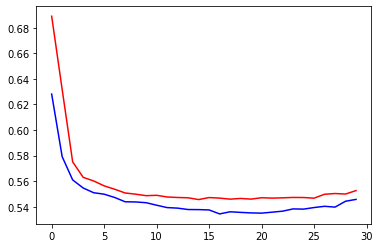

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(log_control['test'], c='r')
plt.plot(log['test'], c='b')

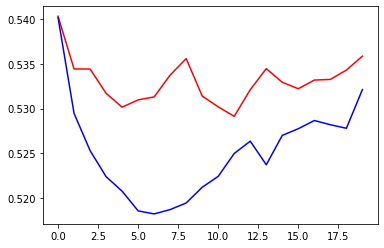

In [33]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(log_control['test'], c='r')
plt.plot(log['test'], c='b')

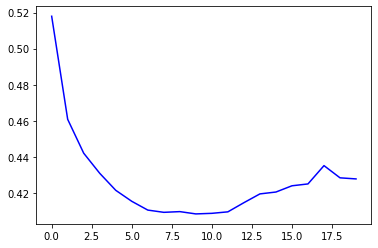

In [14]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(log['test'], c='b')